# Intialize

In [1]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from torchvision import models

import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
import os

In [2]:
device = torch.device('cpu')

# Data Load

In [3]:
from torch.utils.data import Dataset, DataLoader

In [4]:
DATA_PATH = './data/'
DATA_PATH_LIST = os.listdir(DATA_PATH)
DATA_PATH_LIST = [DATA_PATH + path for path in DATA_PATH_LIST]

print(f"Data path list: {DATA_PATH_LIST}")
image_paths = []
for path in tqdm(DATA_PATH_LIST):
    # Remove .DS_Store
    if path == './data/.DS_Store':
        continue

    for file in os.listdir(path):
        image_paths.append(path + '/' + file)

print(f"Image paths: {image_paths}")
print(f"Image path length: {len(image_paths)}")
images = []
for path in tqdm(image_paths[:500]):
    image = cv2.imread(path)
    if image is not None:   image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:                   continue
    images.append(image)
images = np.array(images, dtype='float32')
print(f"Images shape: {images.shape}")

Data path list: ['./data/059-1-1-03-Z4_C', './data/115-1-1-05-Z3_C', './data/019-1-1-01-Z4_C', './data/005-1-1-01-Z58_C', './data/093-1-1-04-Z3_C', './data/006-1-1-01-Z17_C', './data/040-1-1-02-Z4_C', './data/030-1-1-01-Z72_C', './data/002-1-1-01-Z58_C', './data/001-1-1-01-Z17_C', './data/078-1-1-03-Z3_C', './data/110-1-1-04-Z3_C', './data/005-1-1-01-Z4_C', './data/017-1-1-01-Z58_C', './data/010-1-1-01-Z58_C', './data/010-1-1-01-Z4_C', './data/050-1-1-03-Z4_C', './data/039-1-1-02-Z4_C', './data/022-1-1-01-Z116_C', './data/026-1-1-01-Z58_C', './data/105-1-1-04-Z3_C', './data/021-1-1-01-Z58_C', './data/009-1-1-01-Z109_C', './data/008-1-1-01-Z116_C', './data/086-1-1-04-Z3_C', './data/022-1-1-01-Z4_C', './data/062-1-1-03-Z4_C', './data/031-1-1-01-Z116_C', './data/026-1-1-01-Z116_C', './data/100-1-1-04-Z3_C', './data/018-1-1-01-Z116_C', './data/019-1-1-01-Z109_C', './data/011-1-1-01-Z58_C', './data/021-1-1-01-Z116_C', './data/016-1-1-01-Z58_C', './data/119-1-1-05-Z3_C', './data/055-1-1-03-Z

100%|██████████| 229/229 [00:00<00:00, 24845.33it/s]


Image paths: ['./data/059-1-1-03-Z4_C/059-1-1-03-Z4_C-0000005.jpg', './data/059-1-1-03-Z4_C/059-1-1-03-Z4_C-0000011.jpg', './data/059-1-1-03-Z4_C/059-1-1-03-Z4_C-0000010.jpg', './data/059-1-1-03-Z4_C/059-1-1-03-Z4_C-0000004.jpg', './data/059-1-1-03-Z4_C/059-1-1-03-Z4_C-0000012.jpg', './data/059-1-1-03-Z4_C/059-1-1-03-Z4_C-0000006.jpg', './data/059-1-1-03-Z4_C/059-1-1-03-Z4_C-0000007.jpg', './data/059-1-1-03-Z4_C/059-1-1-03-Z4_C-0000013.jpg', './data/059-1-1-03-Z4_C/059-1-1-03-Z4_C-0000017.jpg', './data/059-1-1-03-Z4_C/059-1-1-03-Z4_C-0000003.jpg', './data/059-1-1-03-Z4_C/059-1-1-03-Z4_C-0000002.jpg', './data/059-1-1-03-Z4_C/059-1-1-03-Z4_C-0000016.jpg', './data/059-1-1-03-Z4_C/059-1-1-03-Z4_C-0000014.jpg', './data/059-1-1-03-Z4_C/059-1-1-03-Z4_C-0000028.jpg', './data/059-1-1-03-Z4_C/059-1-1-03-Z4_C-0000029.jpg', './data/059-1-1-03-Z4_C/059-1-1-03-Z4_C-0000015.jpg', './data/059-1-1-03-Z4_C/059-1-1-03-Z4_C-0000001.jpg', './data/059-1-1-03-Z4_C/059-1-1-03-Z4_C-0000018.jpg', './data/059-1-

100%|██████████| 500/500 [00:03<00:00, 146.32it/s]


Images shape: (500, 1080, 1920, 3)


In [5]:
print(f"Converting to numpy array...")
images = torch.Tensor(images).to(device)

Converting to numpy array...


In [6]:
images = images.permute(0, 3, 1, 2)
print(f"Iamges shape: {images.shape}")

Iamges shape: torch.Size([500, 3, 1080, 1920])


In [7]:
skeleton_extractor = models.detection.keypointrcnn_resnet50_fpn(pretrained=True).to(device).eval()
bounding_boxer = models.detection.fasterrcnn_resnet50_fpn(pretrained=True).to(device).eval()

/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=KeypointRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=KeypointRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights

In [8]:
# Image -> Bounding Box -> Skeleton -> Skeleton point as list (Vector)
skeleton_list = []
for image in tqdm(images):
    image = image / 255.0

    with torch.no_grad():
        prediction = bounding_boxer([image.to(device)])
    prediction = prediction[0]
    x1, y1, x2, y2 = prediction['boxes'][0]

    cropped_image = image[:, int(y1):int(y2), int(x1):int(x2)]
    cropped_image = torch.nn.functional.interpolate(cropped_image.unsqueeze(0), size=(256, 512)).squeeze(0)

    with torch.no_grad():
        prediction = skeleton_extractor([cropped_image.to(device)])
    prediction = prediction[0]

    skeleton_point = []
    for i in range(17):
        try:    skeleton_point.append(prediction['keypoints'][0][i][0:2].cpu().numpy())
        except: continue
    skeleton_list.append(skeleton_point)

skeleton_points = np.array(skeleton_list)
print(f"Skeleton points shape: {skeleton_points.shape}")

100%|██████████| 500/500 [22:48<00:00,  2.74s/it]

Skeleton points shape: (500,)



/var/folders/gq/xnxpqv5x7jz19nnym4s4_l940000gn/T/ipykernel_13806/820587806.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  skeleton_points = np.array(skeleton_list)


In [9]:
skeleton_1, skeleton_2, _, _ = train_test_split(skeleton_points, skeleton_points, test_size=0.5, random_state=42, shuffle=True)
print(f"Skeleton 1 shape: {skeleton_1.shape}")
print(f"Skeleton 2 shape: {skeleton_2.shape}")

Skeleton 1 shape: (250,)
Skeleton 2 shape: (250,)


In [10]:
def jaccard_score(skeleton_1, skeleton_2):
    skeleton_1, skeleton_2 = np.array(skeleton_1), np.array(skeleton_2)
    skeleton_1 = skeleton_1.reshape(-1)
    skeleton_2 = skeleton_2.reshape(-1)

    intersection = np.sum(np.minimum(skeleton_1, skeleton_2))
    union = np.sum(np.maximum(skeleton_1, skeleton_2))

    return intersection / union

skeletons_1, skeletons_2 = [], []
labels = []
for i in tqdm(range(len(skeleton_1)), desc="Calculating labels...", total=len(skeleton_1)):
    if len(skeleton_1[i]) == 0 or len(skeleton_2[i]) == 0:
        continue

    labels.append(jaccard_score(skeleton_1[i], skeleton_2[i]))
    skeletons_1.append(skeleton_1[i])
    skeletons_2.append(skeleton_2[i])

labels = np.array(labels)

print(f"Labels shape: {labels.shape}")
print(labels)

Calculating labels...: 100%|██████████| 250/250 [00:00<00:00, 11667.57it/s]

Labels shape: (159,)
[0.5756071  0.50701934 0.39731765 0.55915415 0.59004533 0.39285913
 0.44876382 0.6378382  0.3727473  0.7441231  0.70418775 0.6755474
 0.6469596  0.6375441  0.6098126  0.69996756 0.71896213 0.4636254
 0.711598   0.6666982  0.48193914 0.7098877  0.58670354 0.7379112
 0.34103602 0.51048243 0.73500913 0.34831086 0.4821927  0.572817
 0.67528254 0.7307152  0.613208   0.69566244 0.7059756  0.5956524
 0.8643609  0.71716195 0.56322855 0.66629994 0.66280705 0.3099178
 0.72073776 0.7803018  0.7036106  0.5400461  0.5684885  0.42335534
 0.7996105  0.6284946  0.6440295  0.734809   0.3833011  0.726709
 0.7112481  0.7243542  0.49258396 0.6332789  0.73695856 0.30195132
 0.52161723 0.4322208  0.66178423 0.5559442  0.4770948  0.515251
 0.5371952  0.867415   0.7048712  0.37227473 0.52295005 0.64828914
 0.58994126 0.6098473  0.61602783 0.6381361  0.7261453  0.6189824
 0.4028849  0.7640008  0.55928546 0.69782156 0.34568304 0.53136766
 0.62227124 0.50732267 0.6188594  0.38530052 0.587665

In [14]:
skeletons_1 = np.array(skeletons_1)

guide_X_train, guide_X_test, guide_y_train, guide_y_test = train_test_split(skeletons_1, labels, test_size=0.2, random_state=42)
guide_X_train = guide_X_train.reshape(-1, 34)
guide_X_test = guide_X_test.reshape(-1, 34)

print(f"Guide X train shape: {guide_X_train.shape}")
print(f"Guide y train shape: {guide_y_train.shape}")
print(f"Guide X test shape: {guide_X_test.shape}")
print(f"Guide y test shape: {guide_y_test.shape}")

Guide X train shape: (127, 34)
Guide y train shape: (127,)
Guide X test shape: (32, 34)
Guide y test shape: (32,)


In [16]:
skeletons_2 = np.array(skeletons_2)

user_X_train, user_X_test, user_y_train, user_y_test = train_test_split(skeletons_2, labels, test_size=0.2, random_state=42)
user_X_train, user_X_test = user_X_train.reshape(-1, 34), user_X_test.reshape(-1, 34)
print(f"User X train shape: {user_X_train.shape}")
print(f"User y train shape: {user_y_train.shape}")
print(f"User X test shape: {user_X_test.shape}")
print(f"User y test shape: {user_y_test.shape}")

User X train shape: (127, 34)
User y train shape: (127,)
User X test shape: (32, 34)
User y test shape: (32,)


In [17]:
for idx, y in enumerate(guide_y_train):
    if y == user_y_train[idx]:  continue
    else:   print(f"Guide y: {y}, User y: {user_y_train[idx]}")

In [33]:
class TrainDataset(Dataset):
    def __init__(self, guide_X, guide_y, user_X, user_y):
        self.guide_X = guide_X
        self.guide_y = guide_y
        self.user_X = user_X
        self.user_y = user_y

    def __len__(self):
        return len(self.guide_X)
    
    def __getitem__(self, idx):
        return self.guide_X[idx], self.guide_y[idx], self.user_X[idx], self.user_y[idx]
    
class TestDataset(Dataset):
    def __init__(self, guide_X, guide_y, user_X, user_y):
        self.guide_X = guide_X
        self.guide_y = guide_y
        self.user_X = user_X
        self.user_y = user_y

    def __len__(self):
        return len(self.guide_X)
    
    def __getitem__(self, idx):
        return self.guide_X[idx], self.guide_y[idx], self.user_X[idx], self.user_y[idx]
    
train_dataset = TrainDataset(guide_X_train, guide_y_train, user_X_train, user_y_train)
test_dataset = TestDataset(guide_X_test, guide_y_test, user_X_test, user_y_test)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

## Model

In [34]:
import torch.optim as optim
import torch.nn as nn
import torch

In [43]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.guide_points_skeleton = nn.Linear(34, 1)
        self.consumer_points_skeleton = nn.Linear(34, 1)
        self.score = nn.Linear(2, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, guide_X, user_X):
        guide_X = self.relu(self.guide_points_skeleton(guide_X))
        user_X = self.relu(self.consumer_points_skeleton(user_X))

        x = torch.cat((guide_X, user_X), dim=1)

        x = self.sigmoid(self.score(x))

        return x
    
model = Model().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [46]:
epoch = 300
train_loss, validate_loss = [], []

for epoch in tqdm(range(epoch)):
    running_loss = 0.0
    p_bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
    for i, data in p_bar:
        guide_X, guide_y, user_X, user_y = data
        guide_X, guide_y, user_X, user_y = guide_X.to(device), guide_y.to(device), user_X.to(device), user_y.to(device)

        optimizer.zero_grad()

        outputs = model(guide_X, user_X)
        loss = criterion(outputs, torch.unsqueeze(user_y, 1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        p_bar.set_description(f"Epoch: {epoch}, Loss: {running_loss}")
    train_loss.append(running_loss / len(train_dataloader))

    running_loss = 0.0
    for i, data in enumerate(test_dataloader):
        guide_X, guide_y, user_X, user_y = data
        guide_X, guide_y, user_X, user_y = guide_X.to(device), guide_y.to(device), user_X.to(device), user_y.to(device)

        outputs = model(guide_X, user_X)
        loss = criterion(outputs, torch.unsqueeze(user_y, 1))
        
        running_loss += loss.item()
    validate_loss.append(running_loss / len(test_dataloader))

torch.save(model.state_dict(), './model.pth')

100%|██████████| 300/300 [00:05<00:00, 53.60it/s]


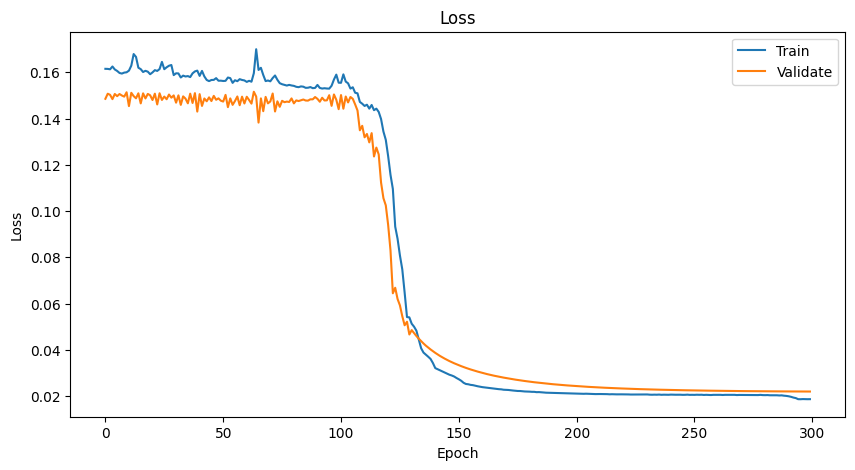

In [47]:
plt.figure(figsize=(10, 5))
plt.title("Loss")
plt.plot(train_loss, label="Train")
plt.plot(validate_loss, label="Validate")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()